<a href="https://colab.research.google.com/github/hedayaahmed/ITNPAI1_Vehicles_Detection/blob/main/2023_Spring_Assignment_AI1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

#University of Stirling - Spring 2023

## ITNPAI1 - Deep Learning for Vision and NLP (2022/3)

---


# 1. **Problem definition** 

This project presents deep learning based solution for vehicles detection including cars, motorcycles, buses, and trucks from wild images at street-level. The dataset is collected from two cities which are Cairo and Stirling.

[top](#scrollTo=4i5afvUbhmGo)
 

---
# 2. **Dataset creation**
202 images from Cairo and 200 images from Stirling are collected using **Mapillary API**. The first step was collecting sequence keys for each city and save them in seperate text file. Then, this [notebook](https://github.com/hedayaahmed/ITNPAI1_Vehicles_Detection/blob/main/Mapillary.ipynb) was used to read these keys and send a request to **Mapillary API** to get response and download these images.

Cairo dataset includes 809 cars, 49 motorcycles, 15 buses, and 57 trucks, while Stirling dataset contains 548 cars, 2 motorcycles, 7 buses, and 19 trucks.

The dataset was annotated using Computer Vision Annotation Tool "CVAT". Then, it is exported in Yolo format and converted to PASCAL VOC format using this [notebook](https://github.com/hedayaahmed/ITNPAI1_Vehicles_Detection/blob/main/Yolo%20to%20PASCAL.ipynb) because the most recent version of CVAT is more accurate in bounding boxes extraction in Yolo and CVAT formats than in PASCAL VOC. The annotation consists of bounding boxes "xmin, ymin, xmax, ymax", object class, and filter label for the repeated, low quality, or empty images to be removed from the final dataset.

[top](#scrollTo=4i5afvUbhmGo)

---

# 4. **Dataloader**

In the following images and annotations reading is impemented. Then, some image preprocessing such as converting images from BGR to RGB, normalization, and resizing. In addition, the dataset splitted to training, validation, and testing. After that, applied data augmentation techniques to increase number of images. Finally, the dataset was loaded into tensor for the next model training step.

[top](scrollTo=4i5afvUbhmGo)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Clone pytorch vision package from its repo
# Obtained from: https://github.com/pytorch/vision
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

Cloning into 'vision'...
remote: Enumerating objects: 322007, done.
remote: Counting objects: 100% (5029/5029), done.
remote: Compressing objects: 100% (587/587), done.
remote: Total 322007 (delta 4597), reused 4829 (delta 4433), pack-reused 316978
Receiving objects: 100% (322007/322007), 653.96 MiB | 28.57 MiB/s, done.
Resolving deltas: 100% (295942/295942), done.
fatal: not a git repository (or any of the parent directories): .git


In [4]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 10.0 MB/s eta 0:00:00


Upload some modified scripts of vision package because it was necessary to edit them to be able to use generated statitics and matrics from training and validation functions in order to visualize losses and mAP matrics.

These scripts are:
- [coco_eval.py](https://github.com/hedayaahmed/ITNPAI1_Vehicles_Detection/blob/main/coco_eval.py)
- [coco_utils.py](https://github.com/hedayaahmed/ITNPAI1_Vehicles_Detection/blob/main/coco_utils.py)
- [engine.py](https://github.com/hedayaahmed/ITNPAI1_Vehicles_Detection/blob/main/engine.py)
- [transforms.py](https://github.com/hedayaahmed/ITNPAI1_Vehicles_Detection/blob/main/transforms.py)
- [utils.py](https://github.com/hedayaahmed/ITNPAI1_Vehicles_Detection/blob/main/utils.py)

![Uploaded scripts](https://drive.google.com/uc?export=view&id=1lDWB19o5pzSVxLJjtmJWYpzbLicR00Sq)

In [5]:
# Import Libraries and packages
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import cv2
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.models.detection import *
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint

from engine import train_one_epoch, evaluate
import utils
import transforms as T

# For image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# As the data directory contains .xml files
from xml.etree import ElementTree as et

import warnings
warnings.filterwarnings('ignore')

### Note: Uncomment the following lines according to the number of Experiment

#### Experiment 1 dataset:

In [12]:
!unzip /content/drive/MyDrive/mix_data.zip

# The following is the training dataset which consists of 101 Cairo images and 100 Stirling images and their annotations. It is the same split for testing
files_dir = '/content/mix_data/Train'
test_dir = '/content/mix_data/Test'

Archive:  /content/drive/MyDrive/mix_data.zip
   creating: mix_data/
  inflating: mix_data/.DS_Store      
  inflating: __MACOSX/mix_data/._.DS_Store  
   creating: mix_data/Test/
   creating: mix_data/Train/
  inflating: mix_data/Test/Egypt_00032_895592191220896.xml  
  inflating: mix_data/Test/Stirling_1448.xml  
  inflating: mix_data/Test/Stirling_0795.jpg  
  inflating: mix_data/Test/Stirling_0795.xml  
  inflating: mix_data/Test/Egypt_00032_895592191220896.jpg  
  inflating: mix_data/Test/Stirling_1448.jpg  
  inflating: mix_data/Test/Egypt_0305.xml  
  inflating: mix_data/Test/Egypt_0488.jpg  
  inflating: mix_data/Test/Egypt_0477.xml  
  inflating: mix_data/Test/Egypt_0305.jpg  
  inflating: mix_data/Test/Egypt_0477.jpg  
  inflating: mix_data/Test/Egypt_0488.xml  
  inflating: mix_data/Test/Egypt_00568_178792447461432.jpg  
  inflating: mix_data/Test/Egypt_00568_178792447461432.xml  
  inflating: mix_data/Test/Egypt_01241_1482868328720362.xml  
  inflating: mix_data/Test/Egypt_

#### Experiment 2 dataset:

In [13]:
#!unzip /content/drive/MyDrive/splited_data.zip
# The following is Stirling dataset when it is splitted into 50% for training and 50% for testing
#files_dir = '/content/Stirling/part2'
#test_dir = '/content/Stirling/part1'

# The following is Egypt dataset when it is splitted into 50% for training and 50% for testing
#files_dir = '/content/Egypt/part1'
#test_dir = '/content/Egypt/part2'

#### Experiment 3 dataset:

In [14]:
# Write your dataloader code here. Create more code cells if you find it necessary

!#unzip /content/drive/MyDrive/full_data.zip

# defining the files directory and testing directory
# files_dir consists of training data, which will be divided into training an validation
# test_dir contains the testing data
#files_dir = '/content/full_data/Egypt'
#test_dir = '/content/full_data/Stirling'

# Exchanged training and testing
#files_dir = '/content/full_data/Stirling'
#test_dir = '/content/full_data/Egypt'

In [15]:
# This is the class of images and annotation reading and some preprocessing
class VehiclesDetectionDataset(torch.utils.data.Dataset):
    
    def __init__(self, files_dir, width, height, transforms=None):
        self.files_dir = files_dir
        self.width = width
        self.height = height
        self.transforms = transforms  # If transformation is required, when transforms is not None
        
        self.classes_ = [_, 'car', 'motorcycle', 'bus', 'truck']  # Defining classes, a blank class is given for the background
        
        self.images = [img for img in sorted(os.listdir(files_dir)) if img[-4:]=='.jpg']
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.files_dir, img_name)
        
        # Reading the image
        img = cv2.imread(img_path)
        
        # Defining width and height
        wt = img.shape[1]
        ht = img.shape[0]
        
        # Converting image to RGB channel, resizing it,  and normalizing the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255.0
        
        annot_name = img_name[:-4] + '.xml'
        annot_path = os.path.join(self.files_dir, annot_name)
        
        # Boxes to store the coordinate points of the bboxes
        boxes, labels = [], []
        
        tree = et.parse(annot_path)
        root = tree.getroot()
        
        # Box coordinates are extracted from the XML files for the given image size
        for member in root.findall('object'):
            labels.append(self.classes_.index(member.find('name').text))
            
            xmin = float(member.find('bndbox').find('xmin').text)
            xmax = float(member.find('bndbox').find('xmax').text)
            ymin = float(member.find('bndbox').find('ymin').text)
            ymax = float(member.find('bndbox').find('ymax').text)
            
            x_min = (xmin/wt)*self.width
            x_max = (xmax/wt)*self.width
            y_min = (ymin/ht)*self.height
            y_max = (ymax/ht)*self.height
            
            boxes.append([x_min, y_min, x_max, y_max])
            
        # Conversion to Tensors   
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])  # Calculating area of the boxes
        
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        
        target = {'boxes': boxes, 'area': area, 'labels': labels, 
                'iscrowd': iscrowd, 'image_id':image_id}
        
        if self.transforms:
            sample = self.transforms(image = img,
                                    bboxes = target['boxes'],
                                    labels = labels)
            
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img, target

In [16]:
# Observing the dataset without any transformation
dataset = VehiclesDetectionDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

length of dataset =  201 



In [17]:
img, target = dataset[78]
print(img.shape, '\n',target)

(224, 224, 3) 
 {'boxes': tensor([[ 50.6406, 151.5208,  58.1875, 158.0833],
        [198.1875, 148.0208, 224.0000, 168.4375],
        [ 96.0312, 151.5208, 108.8281, 164.5000],
        [112.9844, 151.3750, 121.4062, 159.6875],
        [ 68.7969, 151.3750,  71.5312, 155.1667],
        [ 71.5312, 152.5417,  75.3594, 156.7708]]), 'area': tensor([ 49.5264, 527.0053, 166.0928,  70.0068,  10.3679,  16.1897]), 'labels': tensor([4, 1, 1, 1, 1, 1]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'image_id': tensor([78])}


In [18]:
def plot_img_bbox(img, target):
    
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    
    label_count = 0
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        if(target['labels'][label_count]) == 1:
            class_label = 'car'
        if(target['labels'][label_count]) == 2:
            class_label = 'motorcycle'
        if(target['labels'][label_count]) == 3:
            class_label = 'bus'
        if(target['labels'][label_count]) == 4:
            class_label = 'truck'
        label_count = label_count+1
        
        a.annotate(class_label, (box[0]+5, box[1]-5), color='blue', weight='bold', fontsize=10, ha='center', va='center')
        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

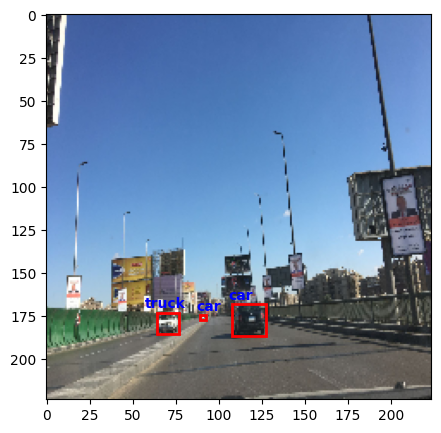

In [19]:
# Visualize some samples from the dataset
img, target = dataset[25]
plot_img_bbox(img, target)

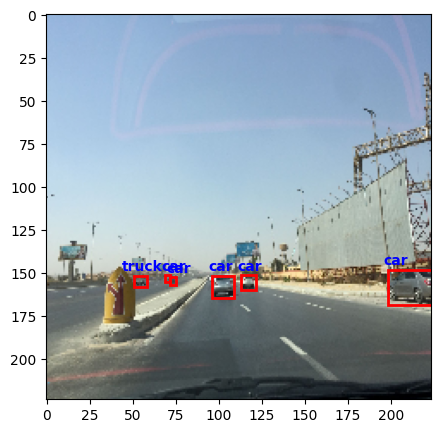

In [20]:
img, target = dataset[78]
plot_img_bbox(img, target)

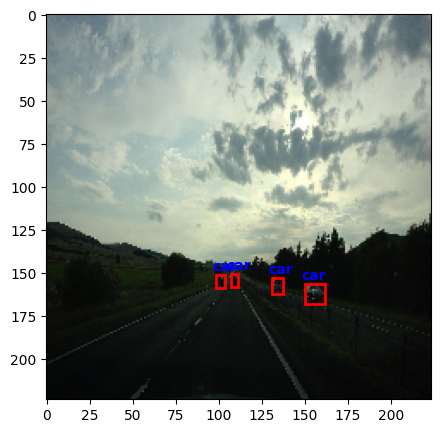

In [21]:
img, target = dataset[120]
plot_img_bbox(img, target)

In [22]:
# Perform data augmentation such as horizontal flip, Changing brightness and contast, adding fog, and adding gaussian blur for the training images
def get_transform(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.RandomFog(p=0.5, fog_coef_lower=0.2, fog_coef_upper=0.4),
            A.GaussianBlur(p=0.5),
            ToTensorV2(p=0.1),     # ToTensorV2 converts image to PyTorch tensor without dividing by 255
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            ToTensorV2(p=0.1),     # ToTensorV2 converts image to PyTorch tensor without dividing by 255
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [23]:
# Define the percentage of training validation split
test_split = 0.2

# Loading the training and the testing data with all the transformations
dataset_train = VehiclesDetectionDataset(files_dir, 480, 480, transforms=get_transform(train=True))
dataset_test = VehiclesDetectionDataset(files_dir, 480, 480, transforms=get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# Train test split
tsize = int(len(dataset) * test_split) # Getting the splitting index
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# Defining dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True,
                                              num_workers=4, collate_fn=utils.collate_fn)  # Imported form helper library
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=True,
                                              num_workers=4, collate_fn=utils.collate_fn)

---

# 5. **Proposed solution** 

The proposed solution is Faster R-CNN with ResNet50 as a backbone. In this step of the pipeline, the model was trained on the training set for specified number of epochs using different hyperparamters, and it was evaluated on the validation set. During this, the loss, Mean average precision, and Mean average recall were calculated. Finally, two posprocessing step were implemented, which are appling Non Maximum Suppression "NMS", and converting images tensor to PIL images.

[top](#scrollTo=4i5afvUbhmGo)

In [24]:
import itertools

In [25]:
# Find all permutations of the hyper-parameters values, and 
# use them in model training and evaluation to select the values of the best results like in "Grid search"
# Obtained from: https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
config_perm = {
    'lr': [0.01, 0.005],
    'momentum': [0.9,  0.95],
    'weight_decay': [0.005, 0.001],
}
keys, values = zip(*config_perm.items())
experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(len(experiments))
display(experiments)

8


[{'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.005},
 {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.001},
 {'lr': 0.01, 'momentum': 0.95, 'weight_decay': 0.005},
 {'lr': 0.01, 'momentum': 0.95, 'weight_decay': 0.001},
 {'lr': 0.005, 'momentum': 0.9, 'weight_decay': 0.005},
 {'lr': 0.005, 'momentum': 0.9, 'weight_decay': 0.001},
 {'lr': 0.005, 'momentum': 0.95, 'weight_decay': 0.005},
 {'lr': 0.005, 'momentum': 0.95, 'weight_decay': 0.001}]

In [26]:
def get_model(num_classes, modelName):
    
    # Loading the pre-trained model
    # Obtained from: https://github.com/pytorch/vision
    if modelName == 'fastcnn':
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

In [27]:
# Write your proposed solution code here. Create more code cells if you find it necessary
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 5 # Set it to 5 as 1 class is devoted for background
num_epochs = 25 # Tried different number of epochs but this was the most suitable for this problem especially that, it is a small dataset

In [28]:
def start_training(modelName, num_epochs, num_classes):
    loss = []
    loss_classifier = []
    loss_box_reg = []
    loss_objectness = []

    val_map = []
    val_map_05 = []

    model = get_model(num_classes, modelName)
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.005)

    # Learning rate decreases by 10 every 5 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    for epoch in range(num_epochs):
        # Train a model for the specified number of epochs
        metric = train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=5)
        # Append metric_logger losses to visualize it later and assess the model
        loss.append(metric.meters['loss'].value)
        loss_classifier.append(metric.meters['loss_classifier'].value)
        loss_box_reg.append(metric.meters['loss_box_reg'].value)
        loss_objectness.append(metric.meters['loss_objectness'].value)

        lr_scheduler.step()
        # Change evaluate function in engine.py and coco_eval to store the matrics values and return it, so we can visualize them.
        eval, stats = evaluate(model, dataloader_test, device=device)
        val_map.append(stats[0])
        val_map_05.append(stats[1])
    return model, loss, loss_classifier, loss_box_reg, loss_objectness, val_map, val_map_05

In [29]:
def apply_nms(prediction, threshold):
    # torchvision returns the indices of the boxes to keep which fits the required threshold
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)
    
    final_prediction = prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [30]:
# Function to convert a torch tensor to a PIL Image
def tensorToPIL(img):
    return transforms.ToPILImage()(img).convert('RGB')

---

# 6. **Experimental tests and evaluations** 


Here is the code for training, testing and evaluating your solution. 

[top](#scrollTo=4i5afvUbhmGo)

First of all model training with different hyperparamters was implemented using all permutations "Grid search" to define the best of them in this problem. In the following, there is a table for the results of this experiment for each model.
![Model Comparison Table](https://drive.google.com/uc?export=view&id=1IBiuqkU6RMroGspMwMGXDcXUpEfAjDGI)

As you can observe, the best model was number 0, but because of that, the losses graph shows there is a possibility of overfitting because it is almost consistent, and there is no dramatic and continuous decrease in the loss value, it was better to use model number 4. Here is a comparison between the two models graphs.

![Models Graphs](https://drive.google.com/uc?export=view&id=1d6Lmnl0wRIbsadAsoeUKWcDxLuV74ymC)

In [31]:
# Model testing function with the test data
def test_model(test_dataset):
  pred_list = []
  target_list = []
  for img, target in test_dataset:
    target_list.append(target)
    with torch.no_grad():
        # Find the output prediction of the model for each image in test data
        prediction = fast_rcnn([img.to(device)])[0]
        prediction['boxes'] = prediction['boxes'].cpu()
        prediction['labels'] = prediction['labels'].cpu()
        prediction['scores'] = prediction['scores'].cpu()
        pred_list.append(prediction)
  
  # Calculate mAP
  metric = MeanAveragePrecision(class_metrics=True)
  metric.update(pred_list, target_list)
  pprint(metric.compute())

For this, the following code blocks (*E1*, *E2*, and *E3*) are mandatory:

  - *E1* -  You should use half (50%) of the samples from each dataset for training and leave the other half for testing (50%). 

In [ ]:
# Write your codes for E1 here. Create more code cells if needed
# Start training by calling model configuration
fast_rcnn, loss, loss_classifier, loss_box_reg, loss_objectness, val_map, val_map_05 = start_training('fastcnn', num_epochs, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 78.7MB/s]


In [ ]:
# Plot Mean average precision for model evaluation inn validation data
x_epochs = range(1, len(val_map) + 1)
plt.plot(x_epochs, val_map, label = "mAP@0.50:0.95")
plt.plot(x_epochs, val_map_05, label = "mAP@0.50")
plt.title("Validation mAP")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.show()

In [ ]:
# Plot loss value in each epoch for different measurments like classifier loss, regression of the bounding box loss, and objectness loss
x_epochs = range(1, len(loss_classifier) + 1)
plt.plot(x_epochs, loss_classifier, label = "loss_classifier")
plt.plot(x_epochs, loss_box_reg, label = "loss_box_reg")
plt.plot(x_epochs, loss_objectness, label = "loss_objectness")
plt.title("Training Losses")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Plot the average of all loss values
x_epochs = range(1, len(loss) + 1)
plt.plot(x_epochs, loss, label = "loss")
plt.title("Training Average Losses")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

In [ ]:
# pick one image from the test set
img, target = dataset_test[5]

# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(tensorToPIL(img), target)

prediction['boxes'] = prediction['boxes'].cpu()
prediction['labels'] = prediction['labels'].cpu()
prediction['scores'] = prediction['scores'].cpu()
print('MODEL OUTPUT')
plot_img_bbox(tensorToPIL(img), prediction)

nms_preds = apply_nms(prediction, threshold=0.02)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(tensorToPIL(img), nms_preds)

In [ ]:
# plot sample from the testing data and model prediction
test_dataset = VehiclesDetectionDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[18]
# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    prediction['boxes'] = prediction['boxes'].cpu()
    prediction['labels'] = prediction['labels'].cpu()
    prediction['scores'] = prediction['scores'].cpu()
print('EXPECTED OUTPUT\n')
plot_img_bbox(tensorToPIL(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, threshold=0.01)

plot_img_bbox(tensorToPIL(img), nms_prediction)

One of the most utilized metrics in object detection is Mean Average precision "mAP" using different thresholds. That is why, it is used to assess model performance, here.

In [ ]:
# Test model performance using the testing set
test_model(test_dataset)

  - *E2* - Testing the models in the dataset. You must implement code routines to test the predictive ability of your models using half of each dataset intended for testing. **The model trained in city A must be tested in city A. The model trained in city B must be tested in city B.** Use the evaluation metrics (accuracy, F1-score, AUC, etc) that are most appropriate for your problem. Plot graphs that illustrate the results obtained for each city (A and B). Plot visual examples of correctly (true positive) and incorrectly (false positive) classified samples. 

[top](#scrollTo=4i5afvUbhmGo)


In [ ]:
# Write your codes for E2 here. Create more code cells if needed
# Start training by calling model configuration
fast_rcnn, loss, loss_classifier, loss_box_reg, loss_objectness, val_map, val_map_05 = start_training('fastcnn', num_epochs, num_classes)

In [ ]:
# Plot Mean average precision for model evaluation inn validation data
x_epochs = range(1, len(val_map) + 1)
plt.plot(x_epochs, val_map, label = "mAP@0.50:0.95")
plt.plot(x_epochs, val_map_05, label = "mAP@0.50")
plt.title("Validation mAP")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.show()

In [ ]:
# Plot loss value in each epoch for different measurments like classifier loss, regression of the bounding box loss, and objectness loss
x_epochs = range(1, len(loss_classifier) + 1)
plt.plot(x_epochs, loss_classifier, label = "loss_classifier")
plt.plot(x_epochs, loss_box_reg, label = "loss_box_reg")
plt.plot(x_epochs, loss_objectness, label = "loss_objectness")
plt.title("Training Losses")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Plot the average of all loss values
x_epochs = range(1, len(loss) + 1)
plt.plot(x_epochs, loss, label = "loss")
plt.title("Training Average Losses")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

In [ ]:
# pick one image from the test set
img, target = dataset_test[5]

# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(tensorToPIL(img), target)

prediction['boxes'] = prediction['boxes'].cpu()
prediction['labels'] = prediction['labels'].cpu()
prediction['scores'] = prediction['scores'].cpu()
print('MODEL OUTPUT')
plot_img_bbox(tensorToPIL(img), prediction)

nms_preds = apply_nms(prediction, threshold=0.02)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(tensorToPIL(img), nms_preds)

In [ ]:
# plot sample from the testing data and model prediction
test_dataset = VehiclesDetectionDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[18]
# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    prediction['boxes'] = prediction['boxes'].cpu()
    prediction['labels'] = prediction['labels'].cpu()
    prediction['scores'] = prediction['scores'].cpu()
print('EXPECTED OUTPUT\n')
plot_img_bbox(tensorToPIL(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, threshold=0.01)

plot_img_bbox(tensorToPIL(img), nms_prediction)

In [ ]:
# Test model performance using the testing set
test_model(test_dataset)

  - *E3* - Testing the models crossing datasets. Now, training is on one city and testing in the other. **The model trained in city A must be tested in city B. The model trained in city B must be tested in city A.**

[top](scrollTo=4i5afvUbhmGo)

### Train on Cairo and test on Stirling Experiment:

In [19]:
# Write your codes for E3 here. Create more code cells if needed
fast_rcnn, loss, loss_classifier, loss_box_reg, loss_objectness, val_map, val_map_05 = start_training('fastcnn', num_epochs, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 86.9MB/s]


Epoch: [0]  [ 0/21]  eta: 0:04:41  lr: 0.000255  loss: 2.7498 (2.7498)  loss_classifier: 1.9466 (1.9466)  loss_box_reg: 0.4544 (0.4544)  loss_objectness: 0.1869 (0.1869)  loss_rpn_box_reg: 0.1620 (0.1620)  time: 13.4238  data: 3.1138  max mem: 7190
Epoch: [0]  [ 5/21]  eta: 0:00:55  lr: 0.001503  loss: 2.3755 (2.1870)  loss_classifier: 1.5526 (1.4822)  loss_box_reg: 0.5141 (0.5304)  loss_objectness: 0.0448 (0.0941)  loss_rpn_box_reg: 0.0698 (0.0804)  time: 3.4638  data: 0.5487  max mem: 7350
Epoch: [0]  [10/21]  eta: 0:00:27  lr: 0.002752  loss: 1.4637 (1.7409)  loss_classifier: 0.7553 (1.0625)  loss_box_reg: 0.5285 (0.5042)  loss_objectness: 0.0587 (0.0835)  loss_rpn_box_reg: 0.0705 (0.0906)  time: 2.5275  data: 0.3098  max mem: 7350
Epoch: [0]  [15/21]  eta: 0:00:13  lr: 0.004001  loss: 1.3102 (1.4861)  loss_classifier: 0.5420 (0.8395)  loss_box_reg: 0.4861 (0.4769)  loss_objectness: 0.0649 (0.0811)  loss_rpn_box_reg: 0.0705 (0.0885)  time: 2.1754  data: 0.2222  max mem: 7350
Epoch: 

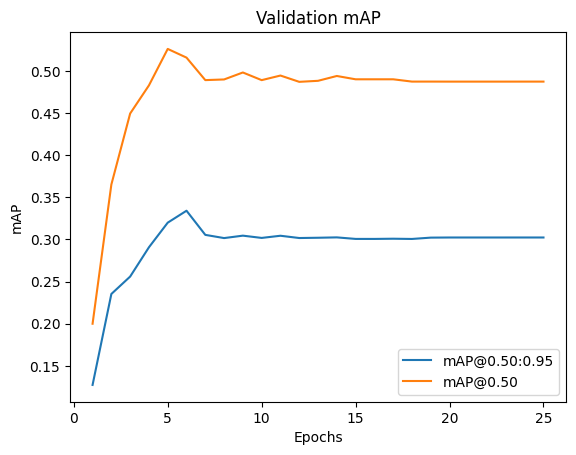

In [20]:
x_epochs = range(1, len(val_map) + 1)
plt.plot(x_epochs, val_map, label = "mAP@0.50:0.95")
plt.plot(x_epochs, val_map_05, label = "mAP@0.50")
plt.title("Validation mAP")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.show()

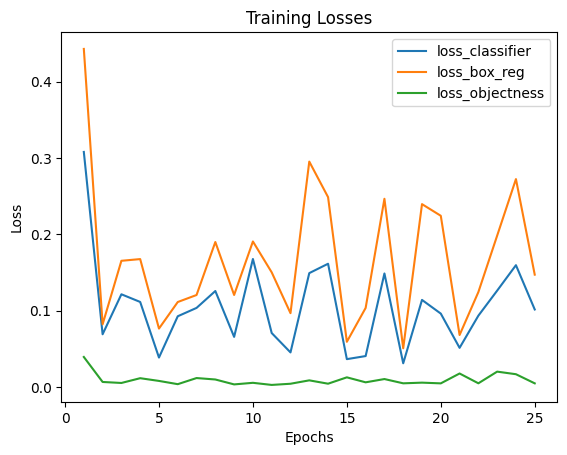

In [21]:
x_epochs = range(1, len(loss_classifier) + 1)
plt.plot(x_epochs, loss_classifier, label = "loss_classifier")
plt.plot(x_epochs, loss_box_reg, label = "loss_box_reg")
plt.plot(x_epochs, loss_objectness, label = "loss_objectness")
plt.title("Training Losses")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

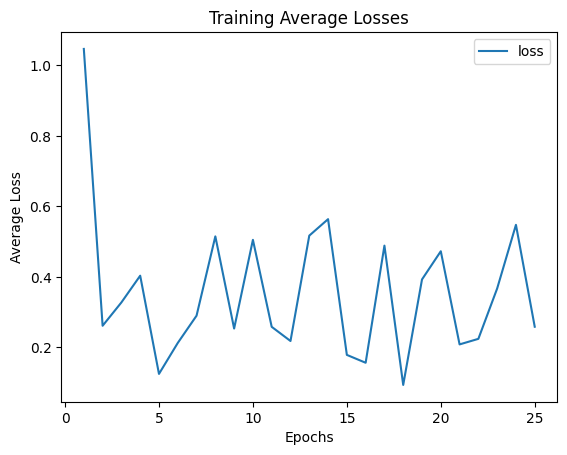

In [22]:
x_epochs = range(1, len(loss) + 1)
plt.plot(x_epochs, loss, label = "loss")
plt.title("Training Average Losses")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

In [25]:
# pick one image from the test set
img, target = dataset_test[5]

# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  21
real #boxes:  2


EXPECTED OUTPUT


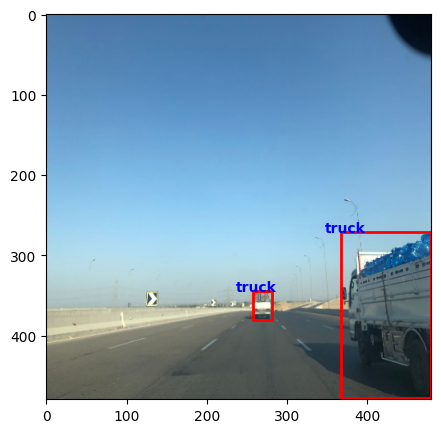

In [26]:
print('EXPECTED OUTPUT')
plot_img_bbox(tensorToPIL(img), target)

MODEL OUTPUT


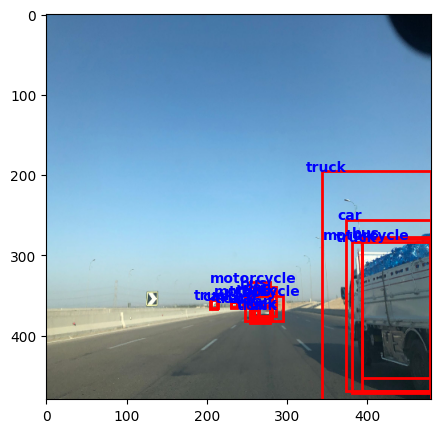

In [27]:
prediction['boxes'] = prediction['boxes'].cpu()
prediction['labels'] = prediction['labels'].cpu()
prediction['scores'] = prediction['scores'].cpu()
print('MODEL OUTPUT')
plot_img_bbox(tensorToPIL(img), prediction)

NMS APPLIED MODEL OUTPUT


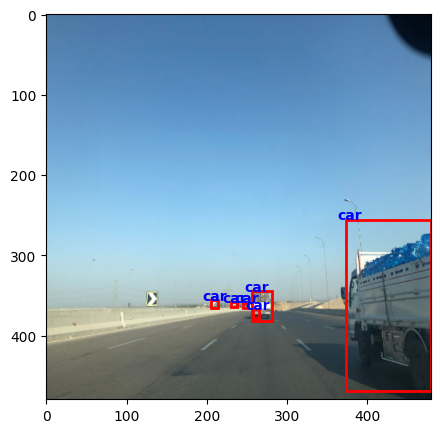

In [28]:
nms_preds = apply_nms(prediction, threshold=0.02)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(tensorToPIL(img), nms_preds)

EXPECTED OUTPUT



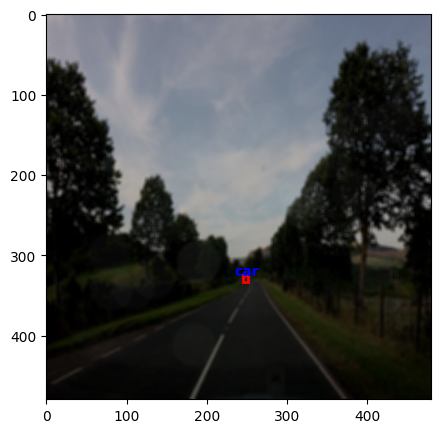

MODEL OUTPUT



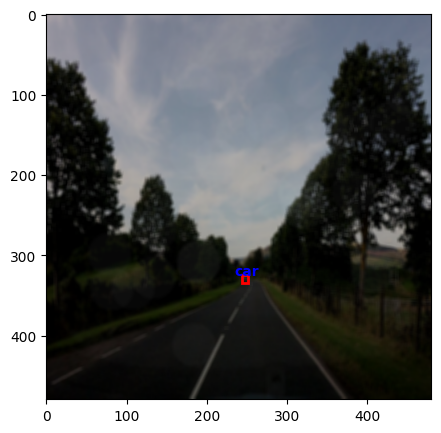

In [35]:
test_dataset = VehiclesDetectionDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[18]
# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    prediction['boxes'] = prediction['boxes'].cpu()
    prediction['labels'] = prediction['labels'].cpu()
    prediction['scores'] = prediction['scores'].cpu()
print('EXPECTED OUTPUT\n')
plot_img_bbox(tensorToPIL(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, threshold=0.01)

plot_img_bbox(tensorToPIL(img), nms_prediction)

In [33]:
test_model(test_dataset)

{'map': tensor(0.1924),
 'map_50': tensor(0.2938),
 'map_75': tensor(0.2090),
 'map_large': tensor(0.6312),
 'map_medium': tensor(0.2642),
 'map_per_class': tensor([0.5821, 0.0017, 0.0250, 0.1609]),
 'map_small': tensor(0.1404),
 'mar_1': tensor(0.2591),
 'mar_10': tensor(0.3632),
 'mar_100': tensor(0.3651),
 'mar_100_per_class': tensor([0.6412, 0.2000, 0.2455, 0.3737]),
 'mar_large': tensor(0.7713),
 'mar_medium': tensor(0.5019),
 'mar_small': tensor(0.1875)}


### Train on Stirling and test on Cairo Experiment:

In [ ]:
# Write your codes for E3 here. Create more code cells if needed
fast_rcnn, loss, loss_classifier, loss_box_reg, loss_objectness, val_map, val_map_05 = start_training('fastcnn', num_epochs, num_classes)

In [ ]:
x_epochs = range(1, len(val_map) + 1)
plt.plot(x_epochs, val_map, label = "mAP@0.50:0.95")
plt.plot(x_epochs, val_map_05, label = "mAP@0.50")
plt.title("Validation mAP")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.show()

In [ ]:
x_epochs = range(1, len(loss_classifier) + 1)
plt.plot(x_epochs, loss_classifier, label = "loss_classifier")
plt.plot(x_epochs, loss_box_reg, label = "loss_box_reg")
plt.plot(x_epochs, loss_objectness, label = "loss_objectness")
plt.title("Training Losses")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training Average Losses")

In [ ]:
x_epochs = range(1, len(loss) + 1)
plt.plot(x_epochs, loss, label = "loss")
plt.title("Training Average Losses")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

In [ ]:
# pick one image from the test set
img, target = dataset_test[5]

# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(tensorToPIL(img), target)

prediction['boxes'] = prediction['boxes'].cpu()
prediction['labels'] = prediction['labels'].cpu()
prediction['scores'] = prediction['scores'].cpu()
print('MODEL OUTPUT')
plot_img_bbox(tensorToPIL(img), prediction)

nms_preds = apply_nms(prediction, threshold=0.02)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(tensorToPIL(img), nms_preds)

In [ ]:
test_dataset = VehiclesDetectionDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[18]
# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    prediction['boxes'] = prediction['boxes'].cpu()
    prediction['labels'] = prediction['labels'].cpu()
    prediction['scores'] = prediction['scores'].cpu()
print('EXPECTED OUTPUT\n')
plot_img_bbox(tensorToPIL(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, threshold=0.01)

plot_img_bbox(tensorToPIL(img), nms_prediction)

In [ ]:
test_model(test_dataset)

---

# 7. **Quiz and Report**

Answer the assessment quiz that will be made available on Canvas one week before the final deadline. Make a 2-page latex report using the [IEEE template](https://www.overleaf.com/read/hkfsjjsxmxcn) with a maximum of 1000 words. You can deliver the report in MS Word if you prefer. Your report should contain five sections: introduction, description of the proposed solution with justifications, results (here you can include the same graphs and pictures generated in this jupyter notebook), discussion of the results, and conclusion. Properly cite references to articles, tutorials, and sources used. A pdf version of your report should be made available in the project's github repository under the name "[project name] + _final_report.pdf".


[top](#scrollTo=4i5afvUbhmGo)


---

# 8. **Demonstration**

Some projects (around 10%) will be selected for a mandatory demonstration. During the demo, you will be asked about implementation details and decisions that led to the design of the developed solution.

[top](#scrollTo=4i5afvUbhmGo)